In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set option to force dataframes to display numbers as floats with thousands separators
pd.set_option('display.float_format', '{:,.3f}'.format)  # Adjust decimal places as needed

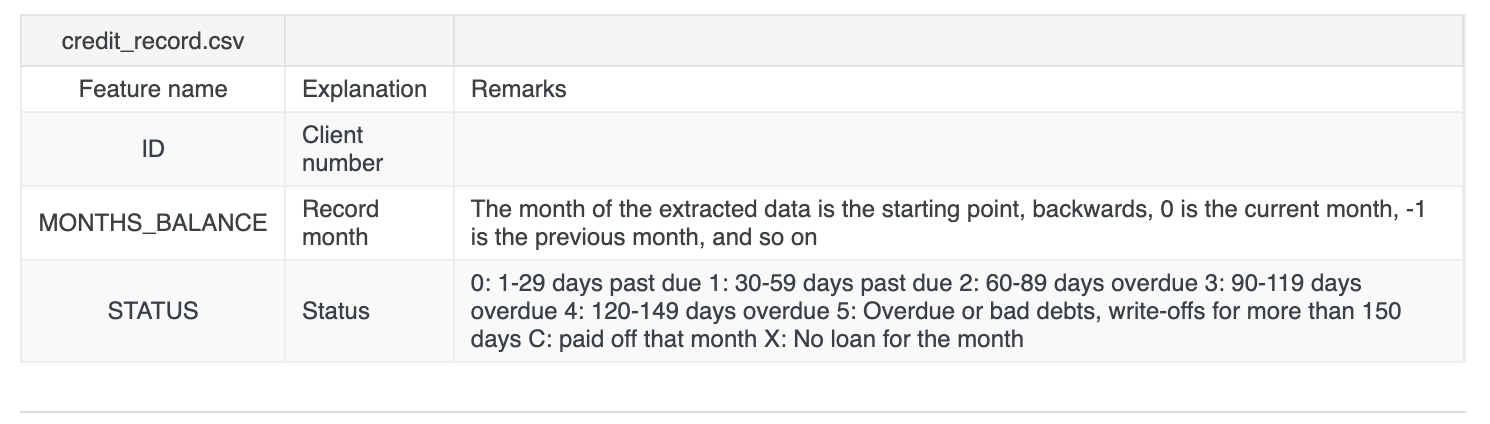

The above is taken from https://www.kaggle.com/code/rikdifos/eda-vintage-analysis/notebook

### Data Preparation

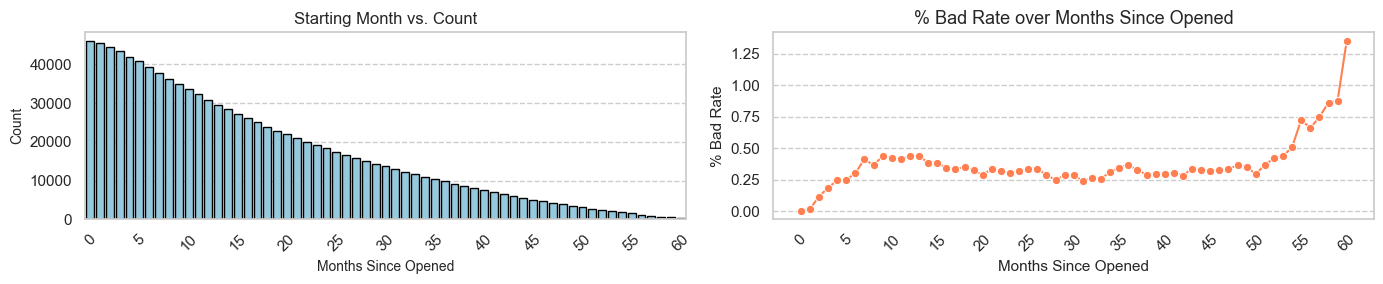

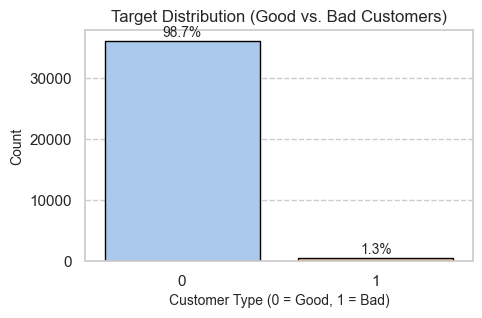

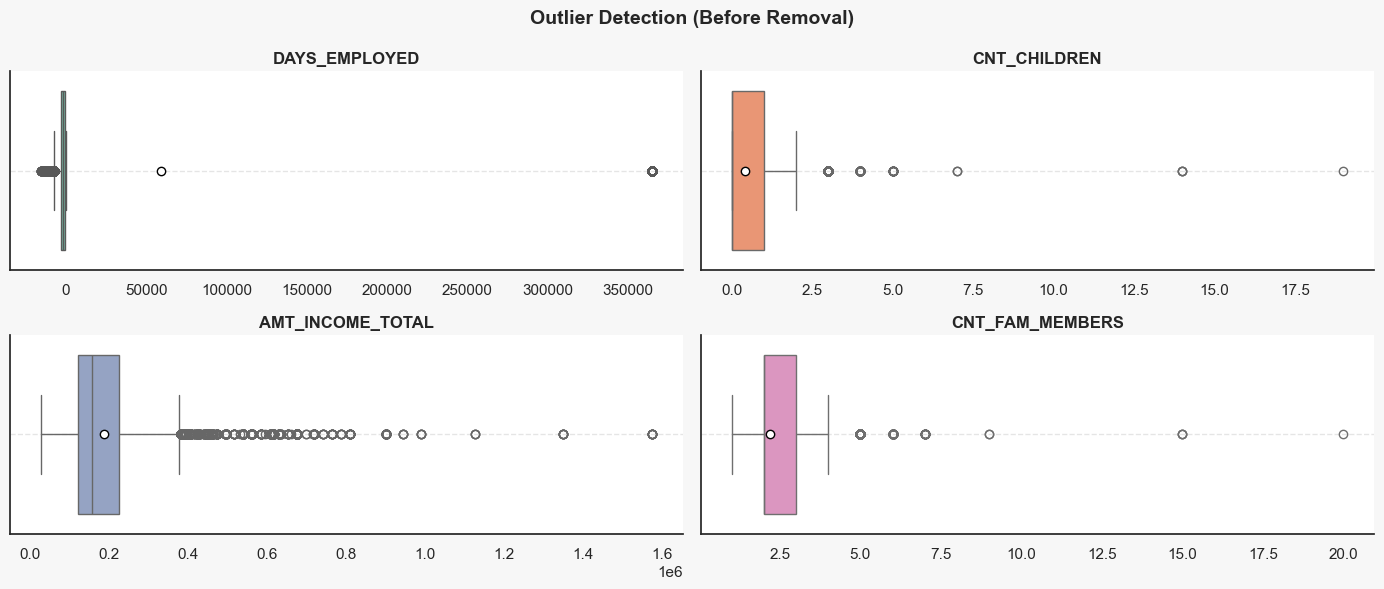

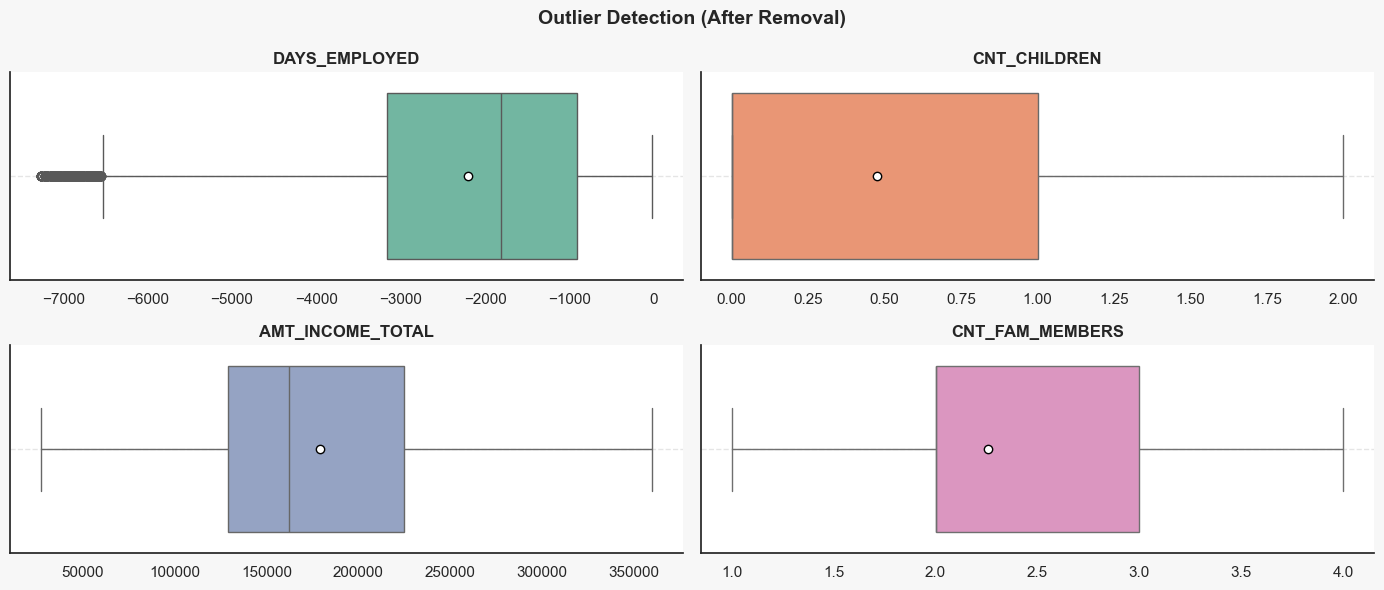

Original merged data shape: (36457, 19)
After outlier removal: (26663, 19)


In [ ]:
# ------------------------------------------------------------------------
# 1. Load and inspect the data (adjust paths/variables to your own setup)
# ------------------------------------------------------------------------
# Define the directory containing the CSV files
directory = ''

# Open the files in a DataFrame for viewing
application_raw_file = os.path.join(directory, 'application_record.csv')
app_record = pd.read_csv(application_raw_file)

credit_raw_file = os.path.join(directory, 'credit_record.csv')
credit_record = pd.read_csv(credit_raw_file)

# ------------------------------------------------------------------------
# 2. Determine the opening month for each customer
# ------------------------------------------------------------------------
opening_months = credit_record.groupby('ID')['MONTHS_BALANCE'].min().rename('opening_month')
credit_record = credit_record.merge(opening_months, on='ID', how='left')
credit_record['MONTHS_SINCE_OPENED'] = credit_record['MONTHS_BALANCE'] - credit_record['opening_month']

# ------------------------------------------------------------------------
# Visualize “Starting Month vs. Count” and Monthly Bad Rate
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
month_distribution = credit_record.groupby('MONTHS_SINCE_OPENED')['ID'].count()

fig, ax = plt.subplots(1, 2, figsize=(14, 3))

# Left subplot: Starting Month vs. Count
sns.barplot(
    x=month_distribution.index,
    y=month_distribution.values,
    ax=ax[0],
    color='skyblue',
    edgecolor='black'
)
ax[0].set_xlabel('Months Since Opened', fontsize=10)
ax[0].set_ylabel('Count', fontsize=10)
ax[0].set_title('Starting Month vs. Count', fontsize=12)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, which='both', axis='y', linestyle='--')
ax[0].grid(False, which='both', axis='x')

# Right subplot: Monthly Bad Rate
credit_record['bad_flag'] = credit_record['STATUS'].isin(['2','3','4','5']).astype(int)
bad_rate_df = credit_record.groupby('MONTHS_SINCE_OPENED')['bad_flag'].mean() * 100

sns.lineplot(
    x=bad_rate_df.index,
    y=bad_rate_df.values,
    ax=ax[1],
    color='coral',
    marker='o'
)
ax[1].set_xlabel('Months Since Opened', fontsize=11)
ax[1].set_ylabel('% Bad Rate', fontsize=11)
ax[1].set_title('% Bad Rate over Months Since Opened', fontsize=13)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, which='both', axis='y', linestyle='--')
ax[1].grid(False, which='both', axis='x')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------
# 3. Create the target variable (1=bad, 0=good) based on first 12 months
# ------------------------------------------------------------------------
first_year = credit_record[credit_record['MONTHS_SINCE_OPENED'] <= 12]
target_per_id = first_year.groupby('ID')['bad_flag'].max().rename('target')

# Use an inner join so only customers with 12-month coverage are included
app_record = app_record.merge(target_per_id, on='ID', how='inner')

# ------------------------------------------------------------------------
# Target Distribution (Good vs. Bad Customers)
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
target_counts = app_record['target'].value_counts().sort_index()  # ensures order: 0 then 1

df_target = target_counts.reset_index()
df_target.columns = ['customer_type', 'count']

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    data=df_target,
    x='customer_type',
    y='count',
    hue='customer_type',
    palette="pastel",
    dodge=False,
    edgecolor="black",
    ax=ax
)
if ax.get_legend() is not None:
    ax.legend_.remove()

ax.set_xlabel("Customer Type (0 = Good, 1 = Bad)", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Target Distribution (Good vs. Bad Customers)", fontsize=12)
ax.grid(True, which='both', axis='y', linestyle='--')
ax.grid(False, which='both', axis='x')

total = target_counts.sum()
percentages = (target_counts / total * 100).round(1)
for i, row in df_target.iterrows():
    ax.text(i, row['count'] + total * 0.005, f"{percentages[i]}%", ha='center', va='bottom', fontsize=10)

plt.show()

# ------------------------------------------------------------------------
# 4. Handling Outliers (Visualization and Removal)
# ------------------------------------------------------------------------
def plot_boxplots(data, columns, title):
    """
    Plots a 2x2 grid of horizontal boxplots for the specified columns
    with cleaner styling (dashed horizontal grid, no vertical grid).
    """
    sns.set_theme(style='white', font_scale=1.0)
    custom_colors = sns.color_palette("Set2", n_colors=len(columns))

    fig, axes = plt.subplots(2, 2, figsize=(14, 6), facecolor="#F7F7F7")
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(
            data=data,
            x=col,
            ax=axes[i],
            color=custom_colors[i],
            showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "white",
                "markeredgecolor": "black",
                "markersize": 6
            }
        )
        axes[i].set_title(col, fontsize=12, fontweight='semibold')
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        axes[i].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
        axes[i].grid(False, which='major', axis='x')
        sns.despine(ax=axes[i], left=False, bottom=False)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Columns to inspect for outliers
columns_of_interest = ["DAYS_EMPLOYED", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"]

# Visualize the original data (Before Outlier Removal)
plot_boxplots(app_record, columns_of_interest, title="Outlier Detection (Before Removal)")

def remove_outliers_iqr(df, col):
    """
    Removes outliers from df[col] based on the 1.5*IQR rule.
    Returns a filtered DataFrame with outliers removed.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_fence) & (df[col] <= upper_fence)]

# Create a copy for outlier removal
app_record_clean = app_record.copy()

# Apply IQR rule to each column in columns_of_interest
for col in columns_of_interest:
    app_record_clean = remove_outliers_iqr(app_record_clean, col)

# Visualize the clean data (After Outlier Removal)
plot_boxplots(app_record_clean, columns_of_interest, title="Outlier Detection (After Removal)")

# Optional: Print shape changes or summary stats
print("Original merged data shape:", app_record.shape)
print("After outlier removal:", app_record_clean.shape)

Preview of final DataFrame:
       age  work_experience  AMT_INCOME_TOTAL FLAG_OWN_REALTY  CNT_FAM_MEMBERS  \
2 706.000           37.000       112,500.000             Yes            2.000   
3 629.000          100.000       270,000.000             Yes            1.000   
4 629.000          100.000       270,000.000             Yes            1.000   
5 629.000          100.000       270,000.000             Yes            1.000   
6 629.000          100.000       270,000.000             Yes            1.000   

   target  
2       0  
3       0  
4       0  
5       0  
6       0  


/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_46537/746618849.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_46537/746618849.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/6m/9c51nr553j7_3q44vsy7bg_c0000gn/T/ipykernel_46537/746618849.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


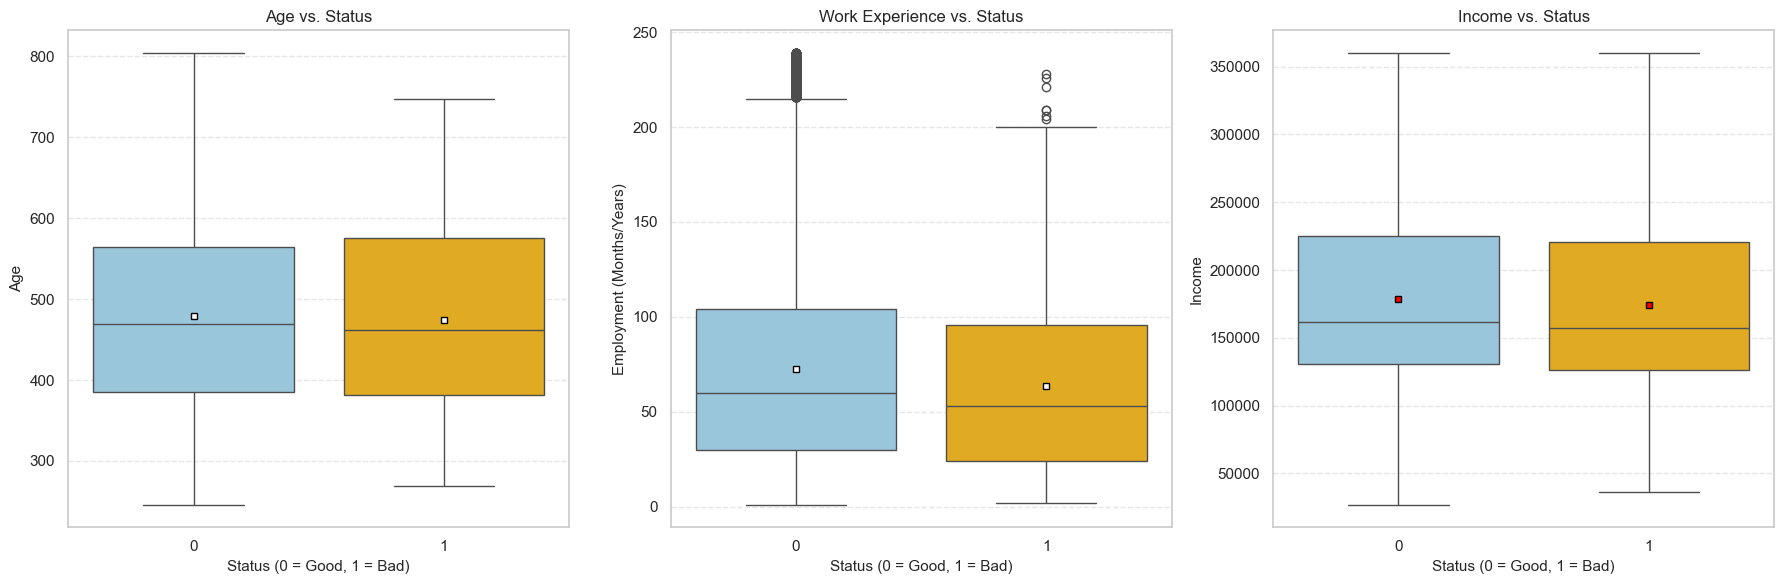

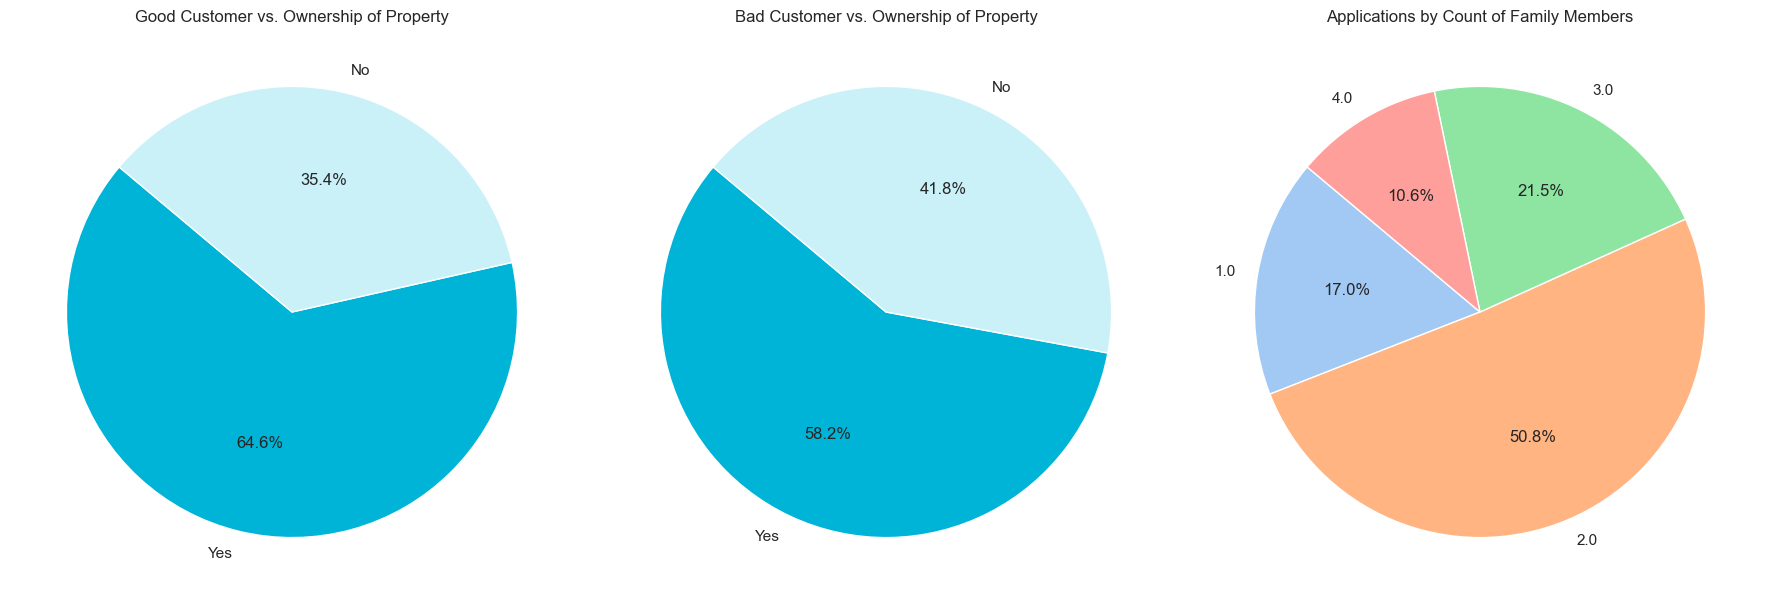

In [58]:
# 1) Create a working DataFrame from your cleaned data
df = app_record_clean.copy()

# Convert DAYS_BIRTH (negative day count) to a positive month count
# Using 30.4 days per month for a more precise conversion
if 'DAYS_BIRTH' in df.columns:
    df['age'] = (-df['DAYS_BIRTH'] / 30.4).round(0)  # Round to whole months

# Convert DAYS_EMPLOYED (negative day count) to a positive month count
if 'DAYS_EMPLOYED' in df.columns:
    df['work_experience'] = (-df['DAYS_EMPLOYED'] / 30.4).round(0)

# If FLAG_OWN_REALTY is Y/N, map it to Yes/No
if 'FLAG_OWN_REALTY' in df.columns:
    df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y': 'Yes', 'N': 'No'})

# Keep only the columns needed for the final visuals
needed_columns = [
    'age',               
    'work_experience',   
    'AMT_INCOME_TOTAL',
    'FLAG_OWN_REALTY',
    'CNT_FAM_MEMBERS',
    'target'
]

df = df[needed_columns].dropna()

print("Preview of final DataFrame:\n", df.head())

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box Plot 1: Age vs. Status
sns.boxplot(
    data=df,
    x='target',
    y='age',
    ax=axes[0],
    palette=['#8ecae6', '#ffb703'],  # Good vs. Bad color
    hue=None,  # explicitly set hue to None to avoid palette warning
    showmeans=True,
    meanprops={
        'marker': 's',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 5
    }
)
axes[0].set_title("Age vs. Status", fontsize=12)
axes[0].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[0].set_ylabel("Age", fontsize=11)
axes[0].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[0].grid(False, which='major', axis='x')

# Box Plot 2: Work Experience vs. Status
sns.boxplot(
    data=df,
    x='target',
    y='work_experience',
    ax=axes[1],
    palette=['#8ecae6', '#ffb703'],
    hue=None,  # explicitly set hue to None
    showmeans=True,
    meanprops={
        'marker': 's',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 5
    }
)
axes[1].set_title("Work Experience vs. Status", fontsize=12)
axes[1].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[1].set_ylabel("Employment (Months/Years)", fontsize=11)
axes[1].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[1].grid(False, which='major', axis='x')

# Box Plot 3: Income vs. Status (with red square for average)
sns.boxplot(
    data=df,
    x='target',
    y='AMT_INCOME_TOTAL',
    ax=axes[2],
    palette=['#8ecae6', '#ffb703'],
    hue=None,  # explicitly set hue to None
    showmeans=True,
    meanprops={
        'marker': 's',
        'markerfacecolor': 'red',  # specifically red for the mean
        'markeredgecolor': 'black',
        'markersize': 5
    }
)
axes[2].set_title("Income vs. Status", fontsize=12)
axes[2].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[2].set_ylabel("Income", fontsize=11)
axes[2].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[2].grid(False, which='major', axis='x')

plt.tight_layout()
plt.show()

# ========== 2) Pie Charts for Property Ownership (Good vs. Bad) and Family Size ==========

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (a) Good Customers vs. Ownership of Property
good_ownership = df[df['target'] == 0]['FLAG_OWN_REALTY'].value_counts()
axes[0].pie(
    good_ownership.values,
    labels=good_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']  # example colors
)
axes[0].set_title("Good Customer vs. Ownership of Property", fontsize=12)

# (b) Bad Customers vs. Ownership of Property
bad_ownership = df[df['target'] == 1]['FLAG_OWN_REALTY'].value_counts()
axes[1].pie(
    bad_ownership.values,
    labels=bad_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']
)
axes[1].set_title("Bad Customer vs. Ownership of Property", fontsize=12)

# (c) Applications by Family Members
fam_counts = df['CNT_FAM_MEMBERS'].value_counts().sort_index()
axes[2].pie(
    fam_counts.values,
    labels=fam_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel", n_colors=len(fam_counts))
)
axes[2].set_title("Applications by Count of Family Members", fontsize=12)

plt.tight_layout()
plt.show()